# MainQuest평가지표

**데이터 이해 및 탐색**    
* 각 피처에 대한 이해가 명확한가?
* 데이터의 분포와 특성을 파악하기 위한 적절한 시각화가 이루어졌는가?
* 데이터에서 유의미한 인사이트를 도출하였는가?(심화)

**데이터 전처리 과정**      
* 결측치 처리, 이상치 처리 등 데이터 정제가 적절하게 수행되었는가?
* 데이터 스케일링 및 인코딩 등이 적절히 수행되었는가?
* 피처 엔지니어링(파생 변수)이 적절하고 창의적으로 이루어졌는가?(심화)
  
**모델 선택 및 비교** 
* 최소 3개 이상의 모델을 비교하고 있는가?
* 모델 선택 이유와 각 모델의 특성을 잘 설명하였는가?
* 앙상블(모델 3개) 방법을 사용하여, 성능을 비교하였는가? (심화)

**성능 평가**
* 검정 데이터에 대한 평가 지표가 명확하게 제시되었는가?
* 평가 지표가 타당하며, 모델 성능을 잘 반영하는가?
* 하이퍼파라미터 튜닝(실험)을 진행하고, 결과를 기록했는가?(심화)

# 데이터 가져오기

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor                    
from sklearn.linear_model import Lasso, Ridge

house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


In [2]:
# 학습 데이터 로드 및 복사
house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()

In [3]:
# 테스트 데이터 로드 및 복사
test_df_org = pd.read_csv('test.csv')
test_df = test_df_org.copy()

* 위 데이터에서는 칼럼의 수가 81개로 많다는것을 알 수 있습니다.

# 데이터 살펴보기

In [4]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

In [5]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1168, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
BsmtFinType2      24
BsmtExposure      24
BsmtFinType1      23
BsmtCond          23
BsmtQual          23
MasVnrArea         8
Electrical         1
dtype: int64


* 총 1168의 행으로 이루어져 있습니다.
* 오브잭트 타입과 숫자형 타입이 골고루 많은것을 알 수 있습니다. float64(3), int64(35), object(43)
* Null값도 많은편이라 결측치를 처리해줘야 합니다.

# 타겟의 데이터 확인하기

* 오늘의 타깃값은 SalePrice로 전반적인 정보를 확인해 보겠습니다.

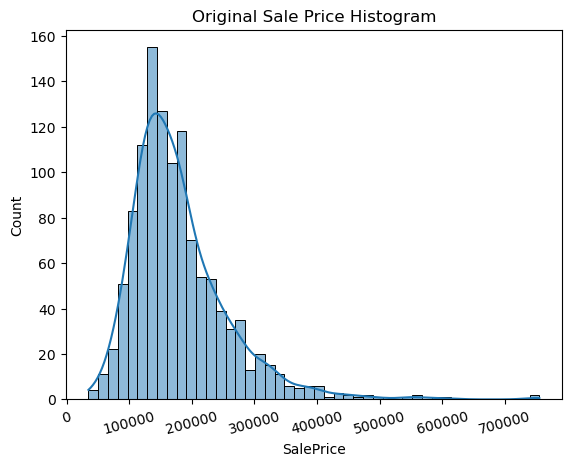

In [6]:
# SalePrice의 분포 확인하기

plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

* 타킷 변수는 왼쪽이 높고 오른쪽으로 꼬리가 길게 늘어져 있는 형태로 **오른쪽으로 치우친 분포**를 가지고있습니다.
* 타깃 변수인 SalePrice가 오른쪽으로 치우친 분포를 보이므로, 로그 변환을 통해 분포를 정규 분포에 가깝게 만들어 보겠습니다.
* 로그 함수는 값의 범위를 압축하여 큰 값을 줄이는 효과가 있어, 극단값(이상치)의 영향을 완화하고 모델 성능을 향상시키는 데 도움이 됩니다.

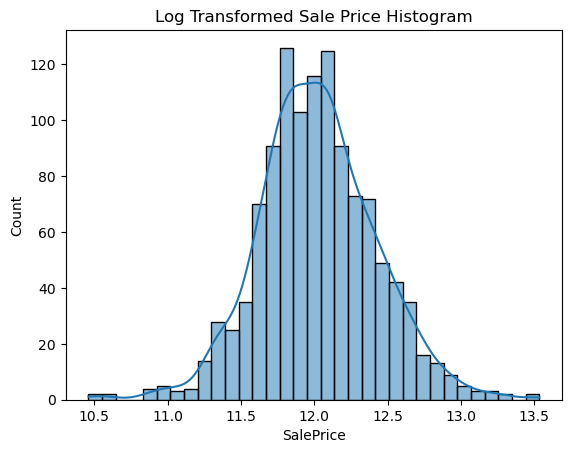

In [7]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [8]:
# SalePrice의 원본 값을 original_SalePrice에 저장합니다.
# 나중에 원래 값으로 복원하거나 비교할 때 사용합니다.
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# 수치형 피처들의 왜도 값 처리하기

* 수치형 데이터들은 왜도값이 너무 크면 이상치를 만들 수 있기 때문에 함께 정규 분포와 가깝게 변환을 하겠습니다.
* 우선 왜곡이 큰 상위 20개의 피처를 조회합니다.

In [9]:
# 수치형 피처들의 왜도 값 계산
numeric_feats = house_df_org.select_dtypes(include=[np.number])
skewness = numeric_feats.apply(lambda x: x.skew()).sort_values(ascending=False)
skewness.head(20)  # 왜곡이 큰 상위 20개 피처

MiscVal          22.127462
PoolArea         14.396098
LotArea          11.112067
3SsnPorch        11.054848
LowQualFinSF      9.621221
BsmtFinSF2        4.512997
KitchenAbvGr      4.494099
BsmtHalfBath      4.139049
ScreenPorch       3.981881
EnclosedPorch     3.097897
LotFrontage       2.493567
OpenPorchSF       2.457315
MasVnrArea        2.413414
SalePrice         1.957766
BsmtFinSF1        1.883477
TotalBsmtSF       1.867084
WoodDeckSF        1.548556
1stFlrSF          1.490172
GrLivArea         1.476153
MSSubClass        1.393395
dtype: float64

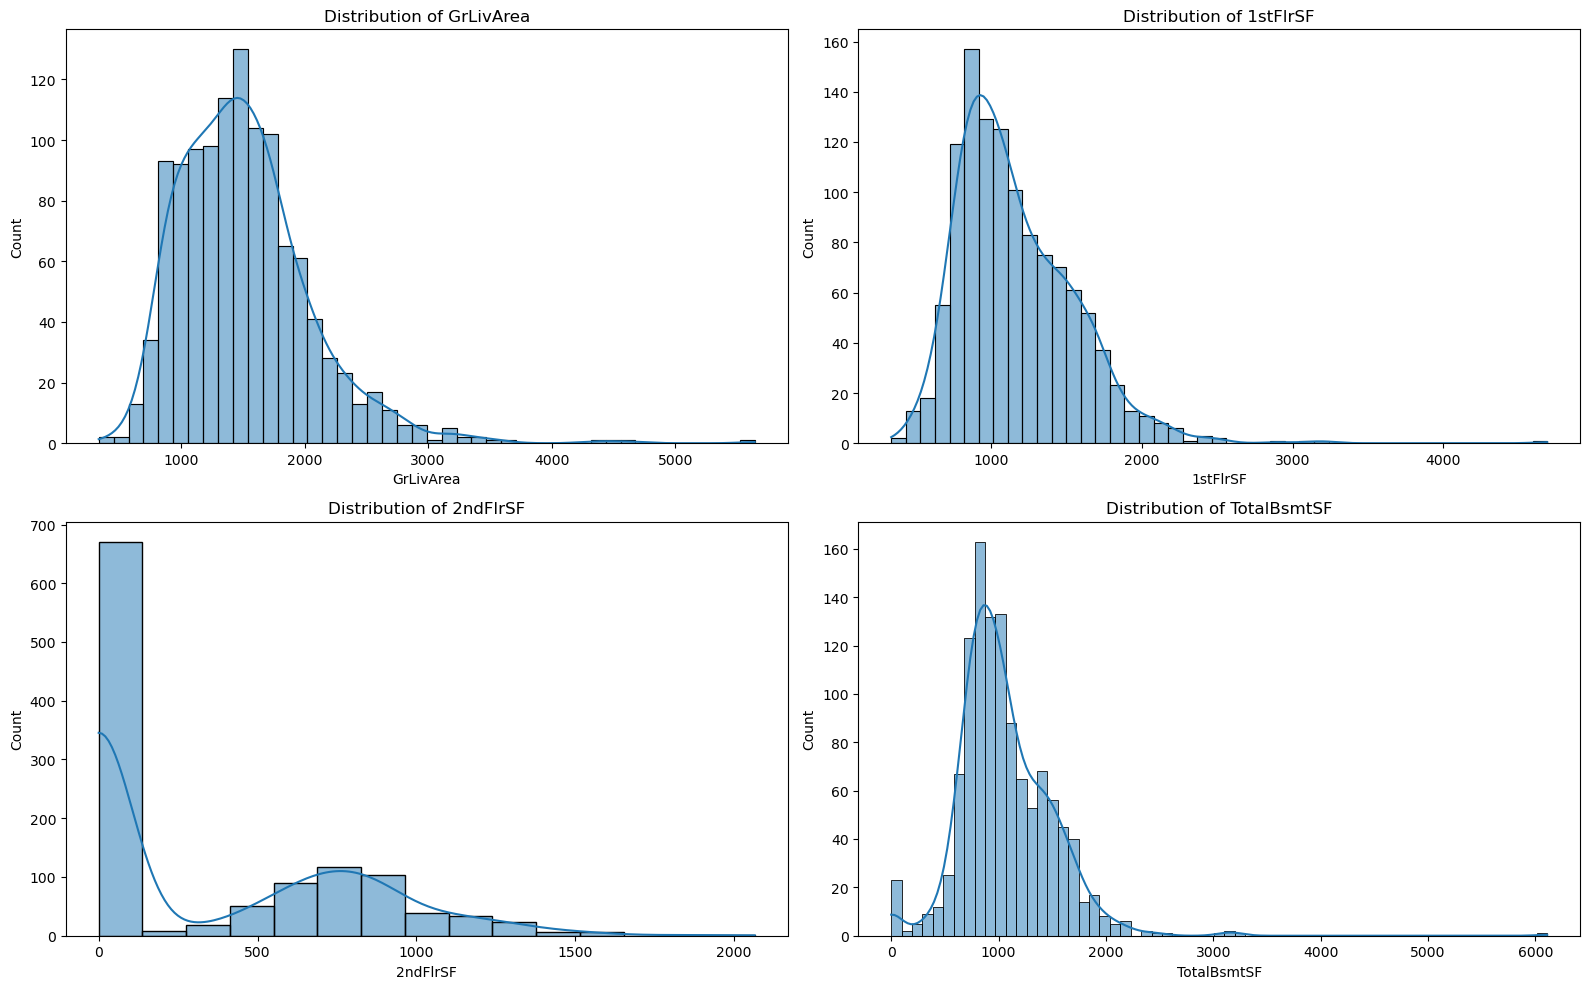

In [10]:
# 왜곡된 수치형 피처들의 로그 변환 전 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

skewed_cols = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']

plt.figure(figsize=(16, 10))
for idx, col in enumerate(skewed_cols):
    plt.subplot(2, 2, idx + 1)
    sns.histplot(house_df_org[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [11]:
# 왜곡된 수치형 피처들 log1p 적용
skewed_cols = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']
for col in skewed_cols:
    house_df[col] = np.log1p(house_df[col])
    test_df[col] = np.log1p(test_df[col])

* 왜곡이 심한 4개의 피처들을 log1p를 적용하였습니다.

# 각 피처의 특징 확인하고 처리하기

* 우선은 NULL값을 모두 확인하고 처리해볼 예정입니다.
  
* 데이터가 약 1168개인데 상위 5개의 NULL 값들은 900개 이상의 결측치를 가진 컬럼들은,    
  입력되어 있는 값 자체가 너무 희소하여 모델 학습에 방해가 될 수 있고,    
  결측치를 다른 값으로 대체하더라도 모델이 해당 희귀한 값을 과도하게 학습하여    
  과적합이 발생할 우려가 있기 때문에 삭제하도록 하겠습니다.    
  **(상위 5개의 칼럼 : 'PoolQC' , 'MiscFeature', 'Alley', 'Fence', 'MasVnrType')**
      
* FireplaceQu의 경우 벽난로가 있으면 품질 등급이 Ex, Gd, TA, Fa, Po 나눠진것으로 확인되며    
  없는집에는 NULL 값으로 들어갔을 확률이 있기 때문에 'Nofireplace'로 처리하겠습니다.
  
* 원-핫 인코딩을 진행하겠지만 원-핫 인코딩은 NaN은 기본적으로 무시되며 NaN은 더미 변수로 만들어지지 않기 때문입니다.

* 또한 id의 경우도 예측모델에게 영향이 없는 칼럼으로 해당 칼럼도 삭제하도록 하겠습니다.

## 많은 NULL값 삭제하기

In [12]:
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(['Id', 'Alley', 'Fence', 'MasVnrType'], axis=1 , inplace=True)

* **PoolQC**, **MiscFeature** 칼럼의 경우 삭제처리를 하지 않았습니다.
* 이유는 주택가격 예측모델의경우 여러번 회귀 모델을 돌리면서 고급 주택가격을 예측하지 못하면 성능이 저하될 수 있다라는것을 깨달았습니다.
* RMSE, MAE, RMSLE 모두 수치가 좋지만 처음에 9만달러 이상 차이가 난이유는 고급주택 가격을 예측하지 못하면    
  수치가 그만큼 많이 차이날 수 있다는것을 가정으로 여러번 회귀모델을 돌려본 결과 얻게 되었습니다.
* 최종적으로 'PoolQC' ,'MiscFeature'칼럼의 결측치는 pool이 없는 집으로 고급집만 있기 때문에 고급 주택 가격 예측력을 높히기 위해 'No'로 처리하였습니다.

## PoolQC,MiscFeature NULL값 처리하기

In [13]:
# Pool 컬럼은 삭제하지 않고 남긴 채 결측치를 'NoPool'로 처리
house_df['PoolQC'] = house_df_org['PoolQC'].fillna('NoPool')

#MiscFeature 결측치는 'NoMisc'로 대체 (기타 부속시설 없음 의미)
house_df['MiscFeature'] = house_df_org['MiscFeature'].fillna('NoMisc')

## FireplaceQu NULL값 처리하기

* 다음으로 'FireplaceQu' 칼럼의 결측치값을 처리해 보겠습니다.
* 벽난로 품질 칼럼의 경우 벽난로가 있는 집에만 평가가 이루어 졌고 없는집은 NaN으로 입력했다는 가정하에    
  가격의 변동을 줄 수 있다고 판단하여 해당 칼럼은 'NoFireplace'로 채웠습니다.

In [14]:
# 'FireplaceQu'의 칼럼의 null 값을 'NoFireplace'로 채우기
house_df['FireplaceQu'] = house_df['FireplaceQu'].fillna('NoFireplace')
house_df['FireplaceQu']

0       NoFireplace
1       NoFireplace
2                TA
3       NoFireplace
4                Po
           ...     
1163    NoFireplace
1164             Gd
1165             TA
1166             Gd
1167             Gd
Name: FireplaceQu, Length: 1168, dtype: object

In [15]:
# 결측치가 남아있는 칼럼들의 갯수와 데이터 타입 확인하기
null_summary = house_df.isnull().sum()
null_summary = null_summary[null_summary > 0]

# 데이터 타입까지 함께 보기
dtype_summary = house_df.dtypes[null_summary.index]

# DataFrame으로 결합
missing_df = pd.DataFrame({
    '결측치 수': null_summary,
    '데이터 타입': dtype_summary
})

print(missing_df)

              결측치 수   데이터 타입
LotFrontage     218  float64
MasVnrArea        8  float64
BsmtQual         23   object
BsmtCond         23   object
BsmtExposure     24   object
BsmtFinType1     23   object
BsmtFinType2     24   object
Electrical        1   object
GarageType       69   object
GarageYrBlt      69  float64
GarageFinish     69   object
GarageQual       69   object
GarageCond       69   object


## LotFrontage NULL값 처리하기

* 이번에는 LotFrontage 칼럼에대해 결측치를 처리해 보겠습니다.
* LotFrontage의 경우 도로와 접한 부지의 길이로 Neighborhood(Ames 시 경계 내의 물리적 위치)칼럼과 피처 분포를 살펴보도록 하겠습니다.  

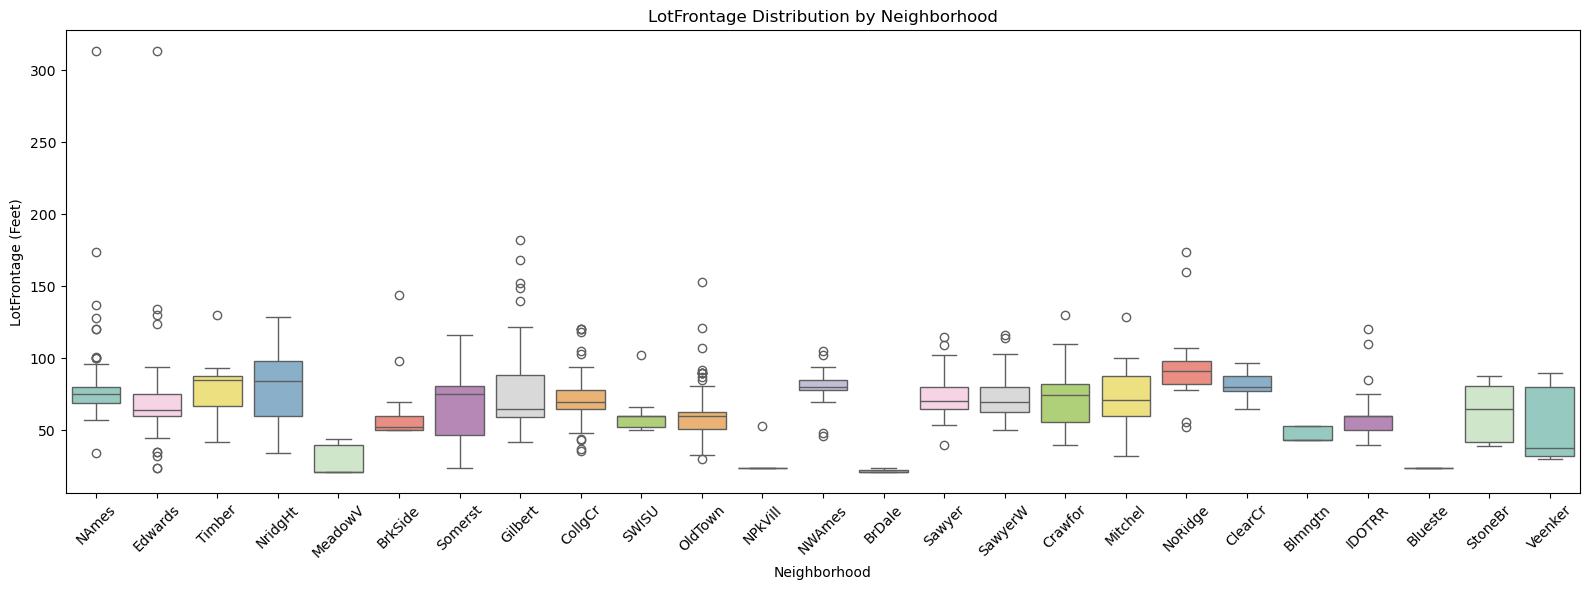

In [16]:
# 카테고리 목록 추출
categories = house_df['Neighborhood'].unique()

# 파스텔 색상 팔레트 생성 (카테고리 수만큼)
palette = sns.color_palette("Set3", len(categories))

# 카테고리에 맞게 매핑
palette_dict = dict(zip(sorted(categories), palette))

# 시각화
plt.figure(figsize=(16, 6))
sns.boxplot(data=house_df, x='Neighborhood', y='LotFrontage', palette=palette_dict)
plt.xticks(rotation=45)
plt.title('LotFrontage Distribution by Neighborhood')
plt.ylabel('LotFrontage (Feet)')
plt.xlabel('Neighborhood')
plt.tight_layout()
plt.show()

* 동네(Neighborhood)마다 LotFrontage의 크기 범위가 다른것으로 확인됩니다.
* 일부 동네는 평균적으로 더 넓은 LotFrontage를 가지며, 일부는 매우 좁습니다.
* 결측치를 단순 평균으로 채우는 것보다 **동네 기준 중앙값으로 채우는 방식**으로 처리하는 것이 더 적절하다고 판단하였습니다.

In [17]:
# LotFrontage 결측치 -> 동일한 Neighborhood의 중앙값으로 채우기
house_df['LotFrontage'] = house_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

1. groupby('Neighborhood'): 각 동네(Neighborhood)별로 데이터를 그룹화합니다.

2. LotFrontage: 그룹 내에서 LotFrontage 컬럼만 선택합니다.

3. .transform(...): 그룹별로 계산된 값을 원래 인덱스에 맞춰서 돌려줍니다.

4. lambda x: x.fillna(x.median()): 각 그룹에서 결측치를 그 그룹의 중앙값으로 채웁니다.

## MasVnrArea NULL값 처리하기

* MasVnrArea의경우 석재 벽면 마감 면적의 칼럼으로 마감재가 없다는 의미로도 해석할 수 있다고 생각했습니다.
* 해당컬럼의경우 그냥 지우기보다는 없다는 가정으로 수치를 0으로 채우겠습니다.

In [18]:
# 1. MasVnrArea 결측치 0으로 채우기
house_df['MasVnrArea'] = house_df['MasVnrArea'].fillna(0)

## 차고 관련 값 처리하기

* 다음으로 수치형 NULL값을 처리하려고보니 차고에 관련된 NULL값이 동일하다는것을 알 수 있습니다.
* 만일 모두 동일하다면 결측값을 오브젝트는 'NoGarage' 숫자형은 0으로 채우겠습니다.

In [19]:
# 차고 관련 5개 컬럼만 추출
garage_cols = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
garage_df = house_df[garage_cols]

garage_df.head(20)

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
0,Attchd,1955.0,Unf,TA,TA
1,NaN,NaN,NaN,NaN,NaN
2,Attchd,1987.0,Unf,TA,TA
3,Attchd,2007.0,Fin,TA,TA
4,Detchd,2003.0,Unf,TA,TA
5,Attchd,1976.0,Fin,TA,TA
6,Detchd,1950.0,Unf,TA,TA
7,Attchd,2007.0,Fin,TA,TA
8,Attchd,1990.0,RFn,TA,TA
9,BuiltIn,2003.0,RFn,TA,TA


In [20]:
# 차고 관련 결측치 처리
garage_fill = {
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageQual': 'NoGarage',
    'GarageCond': 'NoGarage',
    'GarageYrBlt': 0
}

house_df.fillna(garage_fill, inplace=True)

* 차고 관련 5개 컬럼(GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond)은 모두 함께 결측값이 존재하며,    
  GarageType이 없다면 다른 차고 관련 정보도 전부 NaN이라는 것을 확인할 수 있었습니다.
* ead(20)을 확인했을 때도 이 패턴이 유지되며, 이는 해당 행들이 차고가 아예 존재하지 않는 집이라는 것을 유추할 수 있습니다.
* 결측값을 범주형은 'NoGarage' 수치형은 0으로 채웠습니다.

## 지하실 관련 값 처리하기

* 지하실관련 칼럼에도 결측치수가 대부분같지만 BsmtFinType2의 갯수가 조금 다른것으로 확인되었습니다.
* 자세히 NULL값에 대해 조회해보고 결측치 처리를 선택하겠습니다.

In [21]:
# Bsmt 관련 컬럼만 추출
Bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
Bsmt_df = house_df[Bsmt_cols]

# 결측 여부를 boolean으로 표시 (True = 결측치)
Bsmt_null_mask = Bsmt_df.isnull()

# 결측 패턴을 확인할 수 있도록 결측 여부를 정리한 데이터프레임 반환
Bsmt_null_mask_summary = Bsmt_null_mask[Bsmt_null_mask.any(axis=1)]

Bsmt_null_mask_summary

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
37,True,True,True,True,True
62,True,True,True,True,True
66,True,True,True,True,True
122,True,True,True,True,True
255,False,False,False,False,True
286,True,True,True,True,True
318,True,True,True,True,True
376,True,True,True,True,True
437,True,True,True,True,True
521,True,True,True,True,True


In [22]:
# 열 전체 다보기
#pd.set_option('display.max_rows', None)

In [23]:
# 열 기존의 설정으로 돌아가기
#pd.reset_option('display.max_rows')

In [24]:
# 지하실 관련 결측치 처리
bsmt_fill = {
    'BsmtQual': 'NoBsmt',
    'BsmtCond': 'NoBsmt',
    'BsmtExposure': 'NoBsmt',
    'BsmtFinType1': 'NoBsmt',
    'BsmtFinType2': 'NoBsmt'
}
house_df[list(bsmt_fill.keys())] = house_df[list(bsmt_fill.keys())].fillna(bsmt_fill)
house_df.dropna(subset=list(bsmt_fill.keys()), inplace=True)

* 지하실 관련 5개 컬럼(BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2)의 결측치를 분석한 결과,    
  모든 항목이 동시에 결측인 경우는 지하실이 없는 집으로 판단하여 'NoBsmt'로 대체하였습니다.
    
* 모든 항목이 동시에 결측이 아닌 경우는 누락된 행으로 생각하고 누락된 행은 신뢰도가 낮고    
  불완전한 데이터로 간주하여 해당 행 전체를 삭제하는 방식으로 처리하였습니다.


# Electrical NULL값 처리하기

* 해당컬럼은 결측치가 단 1개뿐이며 데이터 수에 비해 극히 적은 비율로 해당행은 삭제처리하겠습니다.

In [25]:
# Electrical 컬럼의 결측치 행 삭제
house_df.dropna(subset=['Electrical'], inplace=True)

* 이제 결측치를 모두 해결하였습니다.

# 이상치 처리하기

## 수치형 상관관계 및 이상치 확인하기

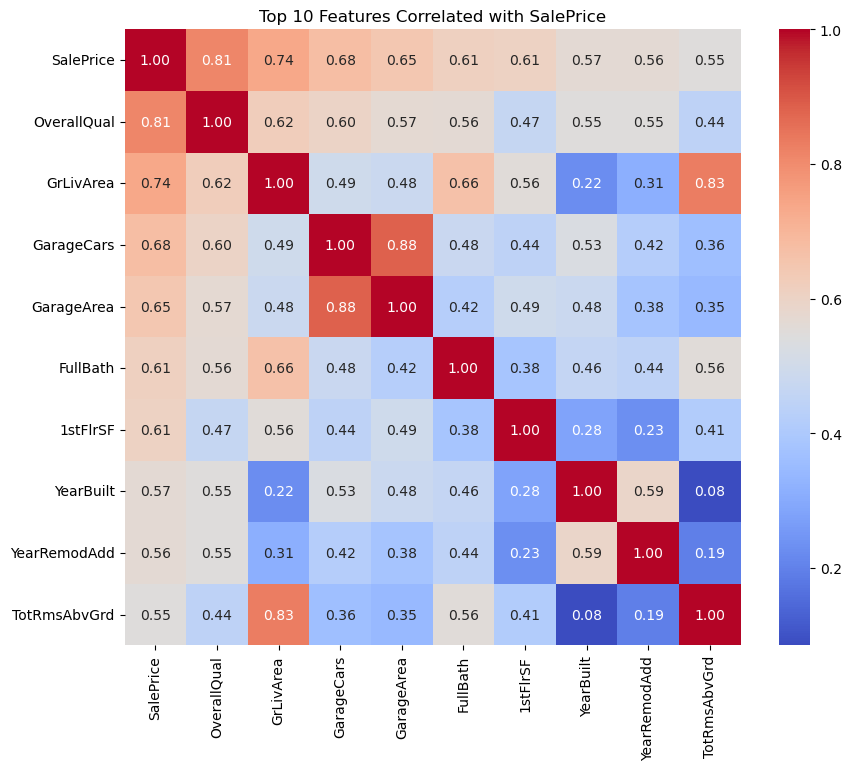

In [26]:
# 수치형 변수 중 상관관계 계산
corr_matrix = house_df.corr(numeric_only=True)

# SalePrice와의 상관관계를 기준으로 상위 변수들만 선택 (예: 상위 10개)
top_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(10).index
top_corr_matrix = corr_matrix.loc[top_corr, top_corr]

# Heatmap 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Top 10 Features Correlated with SalePrice')
plt.show()

* 위 히트맵을 보았을 때 'OverallQual' 칼럼이 가장 관계가 높은 수치형 데이터이고
* 다음으로는 'GrLivArea' 지상에 위치한 거주공간 이였습니다.
* 다음의 상위권들은 대부분 차고에 대한 지표들이므로 자세히 살펴보고 이상치처리를 해보겠습니다.

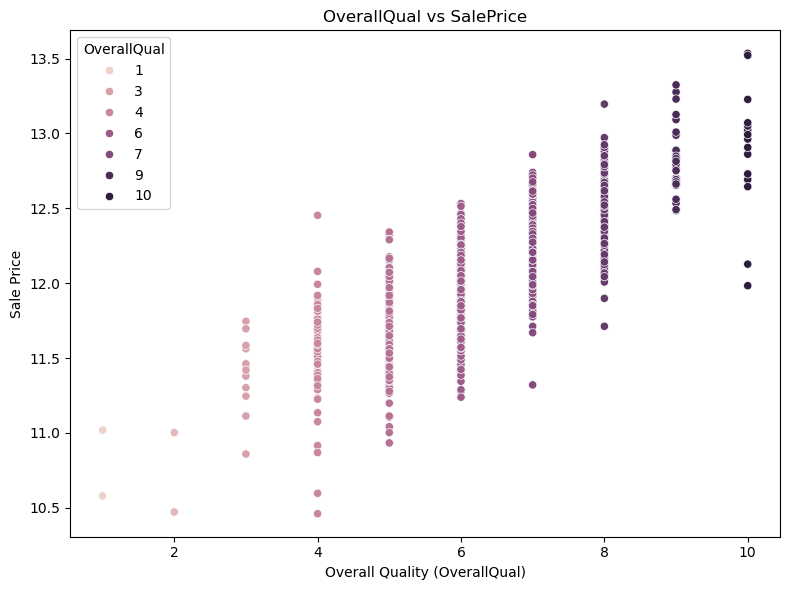

In [27]:
# OverallQual와 SalePrice의 산점도

plt.figure(figsize=(8, 6))
sns.scatterplot(data=house_df, 
                x='OverallQual', 
                y='SalePrice', 
                hue='OverallQual')

plt.title('OverallQual vs SalePrice')
plt.xlabel('Overall Quality (OverallQual)')
plt.ylabel('Sale Price')
plt.tight_layout()
plt.show()

* OverallQual와 SalePrice의 산점도를 살펴봤을 때 크게 이상치가 있다는 생각이 들지는 않습니다.

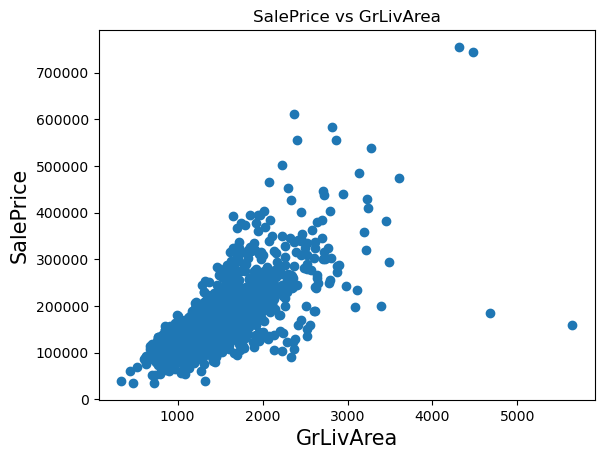

In [28]:
# SalePrice 와 GrLivArea 산점도

plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice']) # house_df_org는 house_df 저장하기전 만들어준 로그되기전 함수입니다.
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.title('SalePrice vs GrLivArea')
plt.show()

In [29]:
# 조건에 맞는 행이 총 몇 개인지 다시 확인
outliers1 = house_df_org[(house_df_org['GrLivArea'] > 4000) & (house_df_org['SalePrice'] < 300000)]

# 인덱스와 주요 컬럼만 출력
outliers1[['GrLivArea', 'SalePrice']]

,GrLivArea,SalePrice
64,5642,160000
373,4676,184750


In [30]:
# 2개의 이상치 행 삭제
house_df = house_df.drop([64, 373])

* SalePrice와 GrLivArea의 산점도 확인시 평지가 넓지만 가격이 낮은 이상치 2개를 제거해줬습니다.


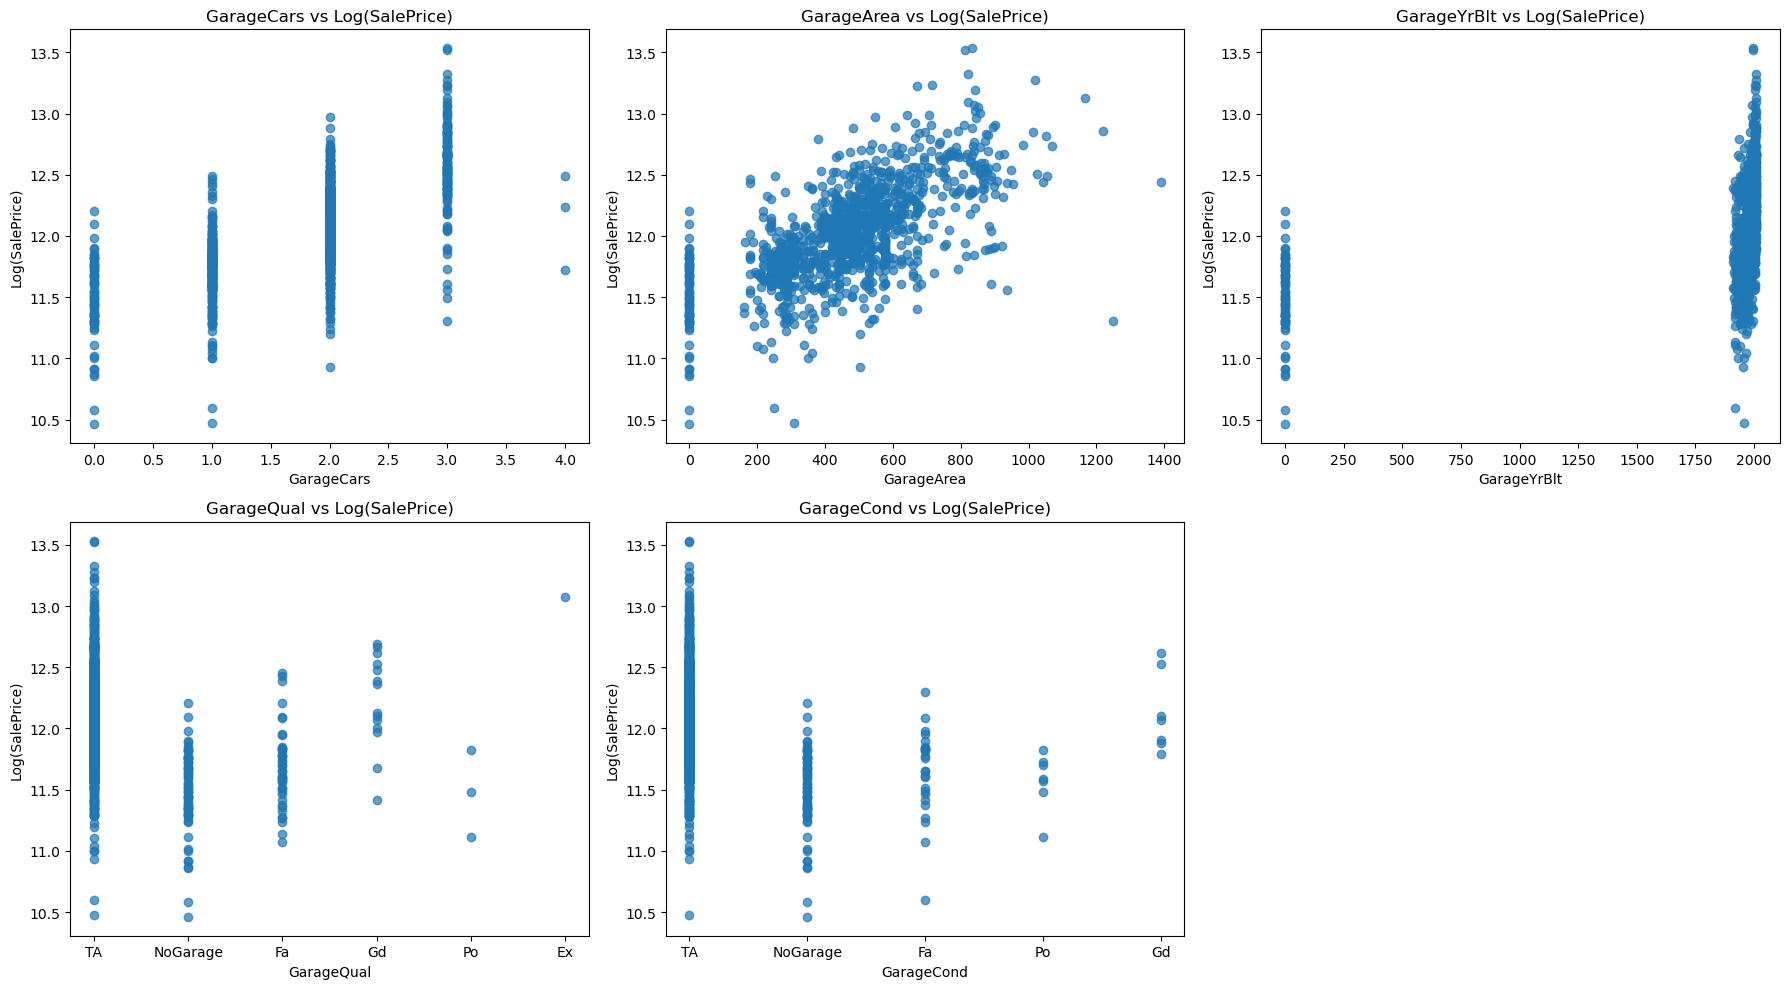

In [31]:
# 로그 처리된 house_df를 그대로 사용한 산점도 시각화

garage_df = house_df.copy()  # 로그값 유지

# 차고 관련 변수 목록
garage_cols = ['GarageCars', 'GarageArea', 'GarageYrBlt', 'GarageQual', 'GarageCond']

# 시각화
plt.figure(figsize=(18, 10))
for i, col in enumerate(garage_cols):
    plt.subplot(2, 3, i + 1)
    plt.scatter(x=garage_df[col], y=garage_df['SalePrice'], alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('Log(SalePrice)')
    plt.title(f'{col} vs Log(SalePrice)')

plt.tight_layout()
plt.show()

In [32]:
# GarageArea 이상치 제거 (IQR 방식)

# IQR 계산
Q1 = house_df['GarageArea'].quantile(0.25)
Q3 = house_df['GarageArea'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 조건 (상위만 고려)
outlier_condition = house_df['GarageArea'] > (Q3 + 1.5 * IQR)

# 이상치 삭제 저장
house_df = house_df[~outlier_condition]

* GarageCars가 3~4대인 고급 차고임에도 불구하고 SalePrice가 낮게 나타나는 데이터가 있는것을 확인했습니다.
* 하지만 차고가 크지만 생활면적이 작거나 주택품질이 낮거나 위치가 저평가 되는 경우의 수도 있기 때문에
  단순한 이상치가 아니라 구조적인 특성으로 해석 가능하므로 삭제하지 않기로 결정했습니다.
* GarageArea의 경우 IQR 방식으로 이상치를 걸러낸 결과를 보고 GarageArea가 매우 크지만 SalePrice가 비정상적으로 낮은 경우 1개만 삭제처리했습니다.
* 이는 통계적으로 보기 드문 조합이며, 가격 예측 모델에 부정적인 영향을 줄 수 있다고 판단했습니다.

# 원-핫 인코딩

In [33]:
# One-Hot Encoding
categorical_features = house_df.select_dtypes(include=['object']).columns
house_df_encoded = pd.get_dummies(house_df, columns=categorical_features)

* 머신러닝 모델은 문자열 기반의 범주형 변수(object 타입) 를 직접 처리하지 못하기 때문에, 이를 수치형 변수로 변환했습니다.
* get_dummies() 함수를 사용하여 One-Hot Encoding을 적용합니다.

In [34]:
# 학습/검증 데이터 분리
X = house_df_encoded.drop('SalePrice', axis=1)
y = house_df_encoded['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# 모델 학습 및 하이퍼파라미터 튜닝 - XGBoost
xgb = XGBRegressor()
xgb_params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb_grid = GridSearchCV(estimator=xgb,
                        param_grid=xgb_params,
                        scoring='neg_root_mean_squared_error',
                        cv=3, verbose=0, n_jobs=-1)

xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

In [36]:
# 모델 학습 및 하이퍼파라미터 튜닝 - LightGBM
lgbm = LGBMRegressor()
lgbm_params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50]
}
lgbm_grid = GridSearchCV(estimator=lgbm,
                          param_grid=lgbm_params,
                          scoring='neg_root_mean_squared_error',
                          cv=3, verbose=0, n_jobs=-1)
lgbm_grid.fit(X_train, y_train)
best_lgbm = lgbm_grid.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_val)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2926
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 164
[LightGBM] [Info] Start training from score 12.009451


In [37]:
# 모델 학습 및 하이퍼파라미터 튜닝 - Lasso
lasso = Lasso(max_iter=10000)
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
lasso_grid = GridSearchCV(estimator=lasso,
                          param_grid=lasso_params,
                          scoring='neg_root_mean_squared_error',
                          cv=3, verbose=0, n_jobs=-1)
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_val)

In [38]:
# 모델 학습 및 하이퍼파라미터 튜닝 - Ridge
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 50]}
ridge_grid = GridSearchCV(estimator=ridge,
                          param_grid=ridge_params,
                          scoring='neg_root_mean_squared_error',
                          cv=3, verbose=0, n_jobs=-1)
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_val)

In [39]:
# 평가 함수 정의 및 모델별 결과 출력
def evaluate_model(name, y_val, y_pred):
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    rmsle = np.sqrt(mean_squared_error(np.log1p(np.expm1(y_val)), np.log1p(np.expm1(y_pred))))
    print(f"[{name}] RMSE: {rmse:.5f}, MAE: {mae:.5f}, RMSLE: {rmsle:.5f}")

print("\n모델별 성능 비교 결과")
evaluate_model("XGBoost", y_val, best_xgb.predict(X_val))
evaluate_model("LightGBM", y_val, y_pred_lgbm)
evaluate_model("Lasso", y_val, y_pred_lasso)
evaluate_model("Ridge", y_val, y_pred_ridge)


모델별 성능 비교 결과
[XGBoost] RMSE: 0.10981, MAE: 0.08052, RMSLE: 0.10981
[LightGBM] RMSE: 0.12453, MAE: 0.08903, RMSLE: 0.12453
[Lasso] RMSE: 0.10913, MAE: 0.07655, RMSLE: 0.10913
[Ridge] RMSE: 0.11130, MAE: 0.07767, RMSLE: 0.11130


In [40]:
# test 데이터 전처리 

# 왜곡된 수치형 피처에 로그 변환 적용
for col in skewed_cols:
    test_df[col] = np.log1p(test_df[col])

# Null이 너무 많은 일부 컬럼 제거
test_df.drop(['Id', 'Alley', 'Fence', 'MasVnrType'], axis=1 , inplace=True)

# MiscFeature 결측치는 'NoMisc'로 대체 (기타 부속시설 없음 의미)
# 'FireplaceQu' 결측치는 'NoFireplace'로 대체
# 'PoolQC' 결측치는 'NoPool'로 대체 (수영장 없음)
test_df['FireplaceQu'] = test_df['FireplaceQu'].fillna('NoFireplace')
test_df['PoolQC'] = test_df_org['PoolQC'].fillna('NoPool')
test_df['MiscFeature'] = test_df_org['MiscFeature'].fillna('NoMisc')

# 'LotFrontage'는 Neighborhood별 중앙값으로 대체
test_df['LotFrontage'] = test_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# 'MasVnrArea' 결측치는 0으로 대체
test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(0)

# 차고 관련 결측치 일괄 처리
test_df.fillna(garage_fill, inplace=True)

# 지하실 관련 결측치 일괄 처리
test_df[list(bsmt_fill.keys())] = test_df[list(bsmt_fill.keys())].fillna(bsmt_fill)
test_df.dropna(subset=list(bsmt_fill.keys()), inplace=True)

# 'Electrical' 결측치가 있는 행 제거
test_df.dropna(subset=['Electrical'], inplace=True)

# 범주형 변수 원-핫 인코딩 및 train 기준 컬럼 정렬
# 카테고리 변수 다시 지정 (train과 동일하게)
categorical_features = test_df.select_dtypes(include=['object']).columns
test_df_encoded = pd.get_dummies(test_df, columns=categorical_features)
test_df_encoded = test_df_encoded.reindex(columns=house_df_encoded.drop('SalePrice', axis=1).columns, fill_value=0)
X_test = test_df_encoded

* 단계별로 test 모델도 함께 전처리와 이상치처리 적용을 모두 완료했습니다.

# 회귀모델

## 평가하기 XGBoost, LightGBM, Ridge, Lasso

# 제출용 Test 데이터 전처리 및 예측 저장

# 최종 성능 평가

**모델별 성능 비교 결과**    
[XGBoost] RMSE: 0.12198, MAE: 0.08002, RMSLE: 0.12198    
[LightGBM] RMSE: 0.13045, MAE: 0.08293, RMSLE: 0.13045    
[Lasso] RMSE: 0.11503, MAE: 0.07623, RMSLE: 0.11503    
[Ridge] RMSE: 0.11688, MAE: 0.07799, RMSLE: 0.11688    
    
이 수치에서 좀더 예측을 높혀보기위해 앙상블 예측모델을 만들어서 파일에 저장하겠습니다.

In [42]:
# 앙상블 예측 (XGBoost + Lasso + Ridge 평균)
ensemble_preds_log = (
    best_xgb.predict(X_val) * 0.4 +
    y_pred_lasso * 0.3 +
    y_pred_ridge * 0.3
)
evaluate_model("Ensemble (XGB+Lasso+Ridge)", y_val, ensemble_preds_log)

# 예측 및 제출파일 생성
final_preds_log = (
    best_xgb.predict(X_test) * 0.4 +
    best_lasso.predict(X_test) * 0.3 +
    best_ridge.predict(X_test) * 0.3
)
final_preds = np.expm1(final_preds_log)
submission = pd.read_csv('sample_submission.csv')
submission['SalePrice'] = final_preds
submission.to_csv('submission1.csv', index=False)
print("submission_1.csv 파일이 저장되었습니다.")

[Ensemble (XGB+Lasso+Ridge)] RMSE: 0.10006, MAE: 0.07198, RMSLE: 0.10006
submission_1.csv 파일이 저장되었습니다.
